In [1]:
import os

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import gymnasium as gym

import gym_env
from utils import decision_policy, woodbury, woodbury_SR, decision_policy_SR
from utils_render import plot_decision_prob_detour
from models import SR_IS, SR_TD

In [2]:
seeds = np.arange(20)

## Parameters
reward = -0.01
term_reward = 10
alpha = 0.05
beta = 1.0
_lambda = 1.0
num_steps = 300000
decay = False
decay_params = [0.99, 150]

# For plotting
prob_locs = [12, 4, 6]
colors = [3, 2, 4]

# Save dir
save_dir = os.path.join('..', 'figures/')

In [ ]:
train_SR = []
test_SR = []
train_SR_IS = []
test_SR_IS = []

for seed in seeds:
    print(f"Seed: {seed}")
    # Define and train models
    SR_IS_agent = SR_IS(env_name="tolman-9x9-nb", reward=reward, term_reward=term_reward, _lambda=_lambda, beta=beta, 
                           alpha=alpha, num_steps=num_steps, policy="softmax", imp_samp=True, 
                           decay=decay, decay_params=decay_params)
    SR_agent = SR_TD(env_name="tolman-9x9-nb", reward=0, term_reward=term_reward, gamma=0.9, beta=beta, alpha=alpha, num_steps=num_steps, policy="softmax", diag=False)

    SR_IS_agent.learn(seed=int(seed))
    SR_agent.learn(seed=int(seed))
    T_pi = decision_policy_SR(agent=SR_agent)

    # Get training decision policy
    pii_SR_IS = decision_policy(SR_IS_agent, SR_IS_agent.Z)
    pii_SR = T_pi

    probs_train_SR_IS = pii_SR_IS[5][prob_locs]
    probs_train_SR_IS_n = probs_train_SR_IS / np.sum(probs_train_SR_IS)
    probs_train_SR = pii_SR[5][prob_locs]
    probs_train_SR_n = probs_train_SR / np.sum(probs_train_SR)

    train_SR.append(probs_train_SR_n)
    train_SR_IS.append(probs_train_SR_IS_n)

    # Get new maze and initialize a new agent
    env_blocked = gym.make("tolman-9x9-b")
    maze_blocked = env_blocked.unwrapped.maze
    new_agent = SR_IS(env_name="tolman-9x9-nb", _lambda=_lambda, beta=beta, alpha=alpha)

    # Block transition
    transition_state = 12
    blocked_state = 15

    T_new = np.copy(SR_IS_agent.T)

    T_new[transition_state, blocked_state] = 0
    T_new[blocked_state, transition_state] = 0

    row_sums = np.sum(T_new, axis=1)

    non_zero_indices = np.where(row_sums != 0)
    T_new[non_zero_indices] /= row_sums[non_zero_indices][:, np.newaxis]

    # Update SR-IS with Woodbury
    D_new = woodbury(SR_IS_agent, T_new, inv=False)

    Z_values_with, V_values_with = np.zeros(new_agent.size), np.zeros(new_agent.size)
    Z_values_with[~SR_IS_agent.terminals] = D_new[~SR_IS_agent.terminals][:,~SR_IS_agent.terminals] @ SR_IS_agent.P @ np.array([np.exp(term_reward)])
    Z_values_with[SR_IS_agent.terminals] = np.exp(term_reward)

    Z_values_with += (np.abs(np.min(Z_values_with)) + 0.1)

    V_values_with = np.log(Z_values_with)

    new_agent.V = V_values_with
    new_agent.DR = D_new
    new_agent.P = T_new[~new_agent.terminals][:,new_agent.terminals]
    new_agent.Z = Z_values_with
    new_agent.V = V_values_with

    pii_SR_IS = decision_policy(new_agent, new_agent.Z)
    probs_test_SR_IS = pii_SR_IS[5][prob_locs]
    probs_test_SR_IS_n = probs_test_SR_IS / np.sum(probs_test_SR_IS)

    # Update SR with Woodbury
    SR_new = woodbury_SR(SR_agent, T_new, T_pi, inv=False)
    SR_agent.SR = SR_new
    SR_agent.update_V()

    pii_SR = decision_policy_SR(agent=SR_agent)
    probs_test_SR = pii_SR[5][prob_locs]
    probs_test_SR_n = probs_test_SR / np.sum(probs_test_SR)

    # Append probs
    test_SR.append(probs_test_SR_n)
    test_SR_IS.append(probs_test_SR_IS_n)

Seed: 0
Seed: 1
Seed: 2
Seed: 3
Seed: 4
Seed: 5
Seed: 6
Seed: 7
Seed: 8
Seed: 9
Seed: 10
Seed: 11
Seed: 12
Seed: 13
Seed: 14
Seed: 15
Seed: 16
Seed: 17
Seed: 18
Seed: 19


## Plot Decision Probabilities

### SR-IS

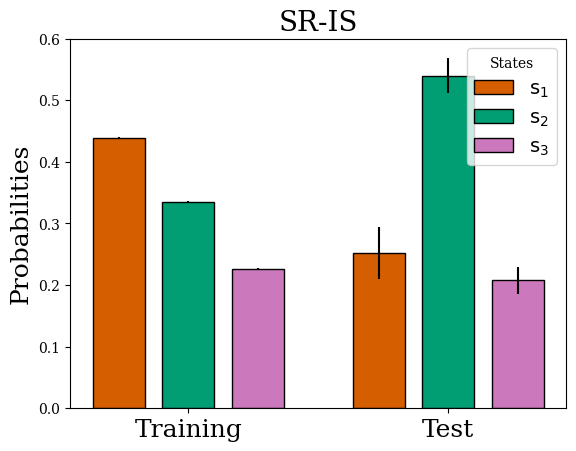

In [8]:
save_path = save_dir + 'detour_SR-IS_final.png'
plot_decision_prob_detour(probs_train=train_SR_IS, probs_test=test_SR_IS, colors=colors, title='SR-IS', save_path=save_path)

### SR

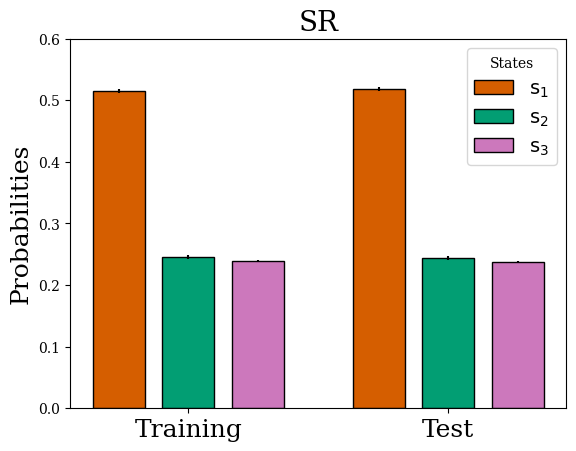

In [9]:
save_path = save_dir + 'detour_SR_final.png'
plot_decision_prob_detour(probs_train=train_SR, probs_test=test_SR, colors=colors, title='SR', save_path=save_path)